In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 8),
            self.gen_block(hidden_dim * 8, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
z_dim = 64
image_size = 299
device = 'cpu' # You're not training here, so do this on CPU

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CelebA(".", download=True, transform=transform)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=076eaed1-21f7-4559-84fd-30692e91ee88
To: /content/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:21<00:00, 66.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 26.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 37.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/celeba/list_landmarks_align_celeba.txt
100

In [5]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"pretrained_celeba (1).pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

In [6]:
!wget https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth


--2024-06-21 07:25:36--  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.38, 18.65.3.63, 18.65.3.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108857766 (104M) [application/octet-stream]
Saving to: ‘inception_v3_google-1a9a5a14.pth’

inception_v3_google 100%[===================>] 103.81M   264MB/s    in 0.4s    

2024-06-21 07:25:36 (264 MB/s) - ‘inception_v3_google-1a9a5a14.pth’ saved [108857766/108857766]



In [7]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [21]:
# You want to replace the final fully-connected (fc) layer
# with an identity function layer to cut off the classification
# layer and get a feature extractor

inception_model.fc = nn.Identity()


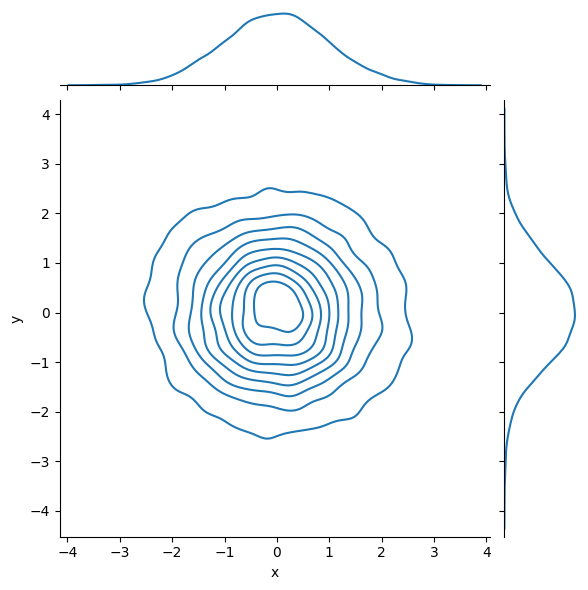

In [22]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
import pandas as pd # Import pandas to create a DataFrame
import matplotlib.pyplot as plt

mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))

# Convert the samples to a Pandas DataFrame
df = pd.DataFrame(samples.numpy(), columns=['x', 'y'])

# Use the DataFrame as input to jointplot
res = sns.jointplot(x='x', y='y', data=df, kind="kde")
plt.show()

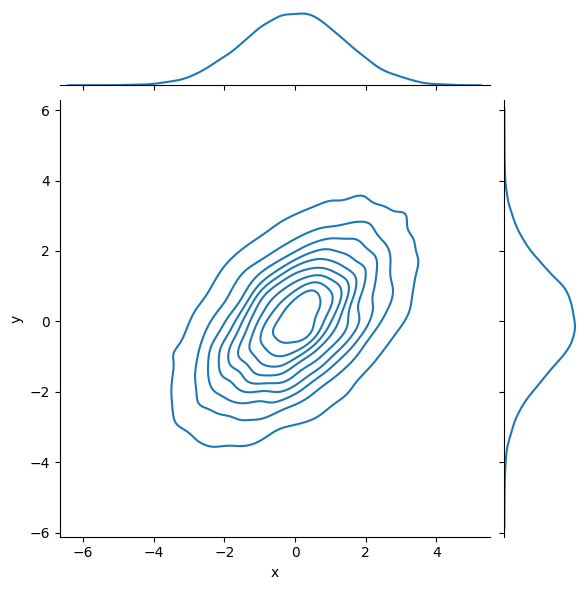

In [23]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, 1],
     [1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
df = pd.DataFrame(samples.numpy(), columns=['x', 'y'])
res = sns.jointplot(x='x', y='y', data = df, kind="kde")
plt.show()

In [24]:
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

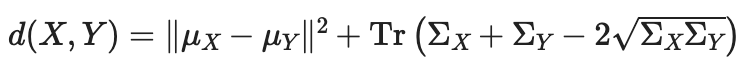

In [25]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features)
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
   # Equation -

    return torch.norm(mu_x - mu_y) **2 + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))


In [26]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [27]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [31]:

fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.inference_mode(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

  0%|          | 0/128 [00:00<?, ?it/s]

In [32]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

In [36]:
fake_features_all

tensor([[0.2866, 0.1637, 0.0359,  ..., 0.5182, 0.0148, 0.2270],
        [0.3829, 0.2751, 0.1096,  ..., 0.5679, 0.0234, 0.1941],
        [0.4048, 0.2811, 0.0849,  ..., 0.4702, 0.6255, 0.6278],
        ...,
        [0.2813, 0.3924, 0.1839,  ..., 0.4696, 0.1090, 0.4073],
        [0.3486, 0.2815, 0.1292,  ..., 0.1088, 0.1473, 0.2757],
        [0.3780, 0.3433, 0.0634,  ..., 0.1140, 0.3624, 0.2036]])

In [73]:
# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [74]:
assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
assert tuple(mu_real.shape) == (real_features_all.shape[1],)
print("Success!")

Success!


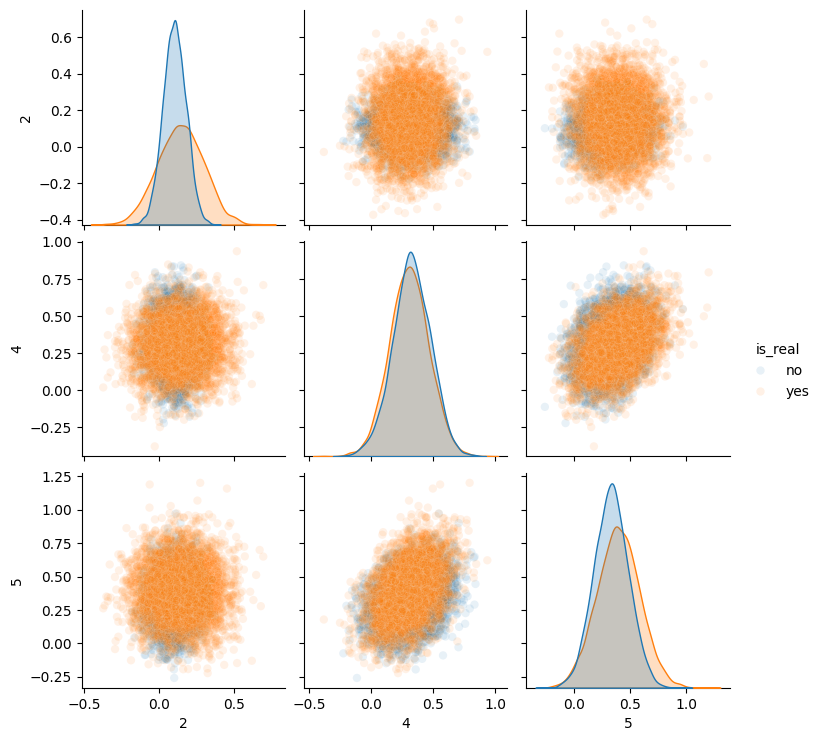

In [75]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

In [76]:
with torch.inference_mode():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

141.16876220703125
